# Using Bureau of Labor Statistics API

**References:**
- URL: https://www.bls.gov/
- Developer API: https://www.bls.gov/developers/home.htm
- Registering for the API V2: https://www.bls.gov/developers/api_faqs.htm#register3
- How to add optional parameters like the secret key to the request: https://www.bls.gov/developers/api_signature_v2.htm#parameters

**Popular series ID:**
- LNS14000000: national unemployment rate - seasonally adjusted
- CUUR0000SA0: consumer price index for all urban consumers (CPI-U)

In [1]:
from datetime import date
from pathlib import Path
import configparser
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import requests
import json

In [2]:
config = configparser.ConfigParser()
config.read(Path.home() / '.config' / 'config.ini')
bls_key = config['bls']['secretkey']

In [3]:
def plot_series_id(series_id: str, series_descr: str, bls_key: str):
    """
    A function that plots a BLS series

    Parameters
    ----------
    series_id : str
        Series ID
    series_descr : str
        Series description
    bls_key : str
        BLS secret key

    Returns
    -------
    A seaborn/MATPLOTLIB line chart with vertical regions or bars to indicate when recessions have occurred
    """
    
    current_year = date.today().year
    start_year = current_year - 19

    headers = {'Content-type': 'application/json'}
    data = json.dumps(
        {
            "seriesid": [series_id],
            "startyear": str(start_year), 
            "endyear": str(current_year),
            "registrationkey": bls_key
        }
    )
    p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
    json_data = json.loads(p.text)
    df_list = []
    for series in json_data['Results']['series']:
        df = pd.DataFrame.from_dict(series['data'])
        # Transformations:
        # Create series_id column
        # Filter to just periods M01, M02, ..., M12
        # Create year-month column as date data type
        # Cast value column as float data type
        # Keep only series_id, year_month, and value columns
        df = (
            df
            .assign(series_id=series['seriesID'])
            .query("(period >= 'M01') & (period <= 'M12')")
            .assign(year_month=pd.to_datetime(
                df['year'].astype('str')+'-'+df['period'].str[-2:], format='%Y-%m')
            )
            .assign(value=df['value'].astype('float'))
        )[['series_id','year_month','value']]
        df_list.append(df)
    
    df_final = pd.concat(df_list, axis='columns')

    fig, ax = plt.subplots(figsize=(8, 5))
    sns.lineplot(
        data=df_final,
        x='year_month',
        y='value',
        ax=ax,
    )
    # Create transparent vertical regions that indicate when recessions happened
    # https://en.wikipedia.org/wiki/List_of_recessions_in_the_United_States
    ax.fill_between(x=['2001-03-01', '2001-11-01'], y1=[int(df_final['value'].max()) + 1, int(df_final['value'].max()) + 1], alpha=0.2, color='gray')
    ax.fill_between(x=['2007-12-01', '2009-06-01'], y1=[int(df_final['value'].max()) + 1, int(df_final['value'].max()) + 1], alpha=0.2, color='gray')
    ax.fill_between(x=['2020-02-01', '2020-04-01'], y1=[int(df_final['value'].max()) + 1, int(df_final['value'].max()) + 1], alpha=0.2, color='gray')
    ax.fill_between(x=['2023-01-01', '2023-08-01'], y1=[int(df_final['value'].max()) + 1, int(df_final['value'].max()) + 1], alpha=0.2, color='blue')
    ax.set_ylim(int(df_final['value'].min()) - 1, int(df_final['value'].max()) + 1)
    sns.despine()
    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.suptitle(series_descr)
    plt.title("grey=recession / blue=current year", fontsize=10)
    plt.show()

#### Plot National Unemployment Rate

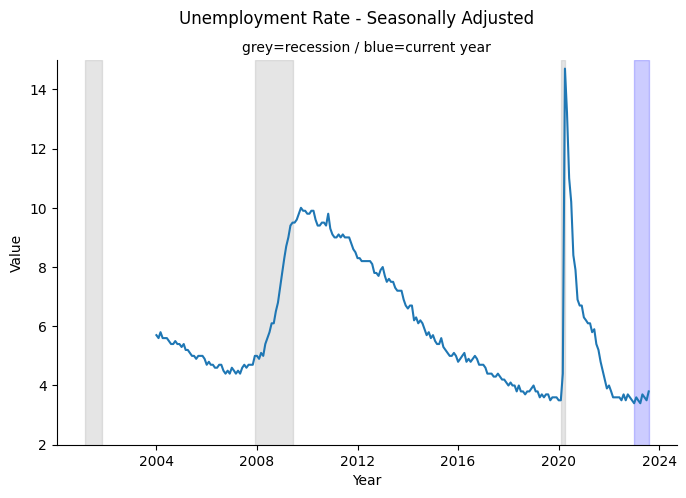

In [4]:
plot_series_id(
    series_id='LNS14000000',
    series_descr='Unemployment Rate - Seasonally Adjusted',
    bls_key=bls_key
)

#### Plot CPI - Seasonally Adjusted

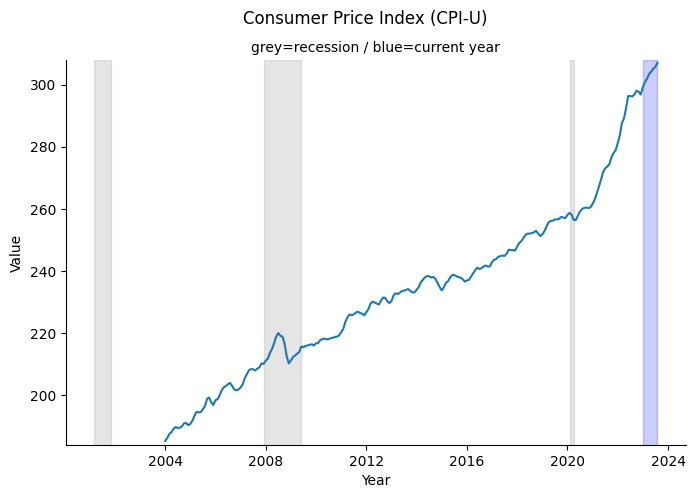

In [5]:
plot_series_id(
    series_id='CUUR0000SA0',
    series_descr='Consumer Price Index (CPI-U)',
    bls_key=bls_key
)